In [3]:
import tensorflow as tf

labels = [
    [1,3,6],
    [1,8,10],
    [5,12,13]
]
labels2 = [
    [1,4,7],
    [2,9,11],
    [5,13,14]
]

# convert and concat in one tensor of size: [2, 3, 3]
labels = tf.concat([tf.expand_dims(tf.convert_to_tensor(labels), 0), tf.expand_dims(tf.convert_to_tensor(labels2), 0)], axis=0)

In [4]:
for i in range(2):
    print(labels[i,:,:])

tf.Tensor(
[[ 1  3  6]
 [ 1  8 10]
 [ 5 12 13]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 1  4  7]
 [ 2  9 11]
 [ 5 13 14]], shape=(3, 3), dtype=int32)


In [94]:
from Tools.LossesAndMetrics.ctc_normal_customRec_tf import m_eye


# from Tools.LossesAndMetrics.ctc_normal_customRec_tf import compute_recurrence_Matrix_from_labels
def compute_recurrence_Matrix_from_labels(labels, seqLen,doSSG):
    """

    :param labels: [batch, U, 3] (3 is classId, start, end)
    :param seqLen: [batch]
    :param doSSG: bool
    :return:
    """
    eps_nan = -1e8
    batch = tf.shape(labels)[0]
    twoUP1 = tf.shape(labels)[1] * 2 + 1 # 2U+1
    U = tf.shape(labels)[1]
    # twoUP1 = len(labels) * 2 + 1 # 2U+1
    #labels.sort(key=lambda x: x[1])
    token = labels[:, :, 0]  # (batch, U)


    # truncate start and end to be inside the sequence (0 and seqLen-1), do it in the labels, keep the same shape
    labels = tf.concat([tf.expand_dims(tf.clip_by_value(labels[:,:,0], 0, seqLen-1), axis=2),
                        tf.expand_dims(tf.clip_by_value(labels[:,:,1], 0, seqLen-1), axis=2),
                        tf.expand_dims(labels[:,:,2], axis=2)], axis=2)


    token_with_blank = tf.concat((tf.zeros([batch, U, 1], dtype=tf.int32), tf.cast(token[:, :, tf.newaxis], tf.int32)),
                                 axis=2)  # (batch, U,2)
    token_with_blank = tf.reshape(token_with_blank, [batch, -1])  # (batch, 2*U)
    # add a blank at the end of elems
    token_with_blank = tf.concat((token_with_blank, tf.zeros([batch, 1], dtype=tf.int32)), axis=1)  # (batch, 2U+1)
    # token_with_blank: [blank, index_e1,blank, index_e2, .... eU, blank]
    token_with_blank = tf.where(token_with_blank == -1, tf.zeros_like(token_with_blank), token_with_blank)

    length = tf.shape(token_with_blank)[1]  # 2U+1


    # recurrence relation
    consecutiveDifferent = tf.cast(tf.not_equal(token_with_blank[:, :-2], token_with_blank[:, 2:]), tf.float32)

    # pad with two blanks on the left
    consecutiveDifferent = tf.concat((tf.zeros((batch, 2), dtype=tf.float32), consecutiveDifferent), axis=1) # (batch, 2U+1)

    # elements not blank in the GT (one on two)
    notBlanksToken = tf.cast(tf.not_equal(token_with_blank, 0), tf.float32)
    # kind of mask : True = Not consecutive identic elements, False = consecutive identic elements: can skip the blank,
    sec_diag = consecutiveDifferent * notBlanksToken  # (batch, 2U+1)

    # m_eye : identity matrix for k=0, ones of are shifted by k

    # recurrence_relation : (batch, 2U+1, 2U+1)
    recurrence_relation = \
        tf.repeat((tf.eye(length) + m_eye(length, k=1))[tf.newaxis], repeats=batch, axis=0) + \
        tf.repeat(m_eye(length, k=2)[tf.newaxis], repeats=batch, axis=0) * sec_diag[:, tf.newaxis, :]
    # tf.print("recurrence_relation\n",recurrence_relation,summarize=-1)
    # recurrence_relation = eps_nan * (tf.ones_like(recurrence_relation) - recurrence_relation)

    # repeat for each time in seqLen -> (batch, seqLen, 2U+1, 2U+1)
    recurrence_relation = tf.repeat(recurrence_relation[:, tf.newaxis, :, :], repeats=seqLen, axis=1)

    # considering the index of frames (start and end) labels[:, :, 1:3], create the tensor of the shape [batch,seqLen,U] with ones if the class is present in the frame
    # (batch, seqLen, U, 2)
    actionPosition = tf.repeat(tf.expand_dims(labels[:, :, 1:3], axis=1), repeats=seqLen, axis=1)
    # (batch, seqLen, U)
    actionPosition = tf.cast(tf.logical_and(tf.repeat(tf.range(seqLen)[tf.newaxis,:,tf.newaxis], repeats=U, axis=2) >= actionPosition[:, :, :, 0]-1,
                                       tf.repeat(tf.range(seqLen)[tf.newaxis,:,tf.newaxis], repeats=U, axis=2) <= actionPosition[:, :, :, 1]-1), tf.float32)

    # in the last dim, add zeros between each element, and before and after
    start_end = actionPosition[:, :, :, tf.newaxis]
    start_end = tf.pad(start_end, [[0, 0], [0, 0], [0, 0], [0, 1]], constant_values=1)
    # (batch, seqLen, 2U+1, 2U+1)
    start_end = tf.reshape(start_end, [batch, seqLen, twoUP1-1])
    #pad with zeros on the left (only one zero at right)
    start_end = tf.concat((tf.ones((batch, seqLen, 1), dtype=tf.float32), start_end), axis=2)

    recurrence_relation = recurrence_relation * (start_end[:, :, tf.newaxis, :])
    # print("start_end", start_end[0])


    if not doSSG: #HSG
        # remove actions to blank if we are on action
        blankPosition = 1-actionPosition
        blank_start_end = blankPosition[:, :, :, tf.newaxis]
        blank_start_end = tf.pad(blank_start_end, [[0, 0], [0, 0], [0, 0], [1, 0]], constant_values=1)
        blank_start_end = tf.reshape(blank_start_end, [batch, seqLen, twoUP1-1])
        blank_start_end = tf.concat((tf.ones((batch, seqLen, 1), dtype=tf.float32), blank_start_end), axis=2)
        # print("blank_start_end", blank_start_end[0])
        recurrence_relation1 = recurrence_relation * (blank_start_end[:, :, tf.newaxis, :])

        actionPositionShifted2 = tf.pad(actionPosition[:,1:,:], [[0,0],[0,1],[0,1]])
        #shift of two on the last dim, take from 2: and pad with zeros
        #make a logical and between consecutive columns of last dim (convert to bool)
        boolAct = tf.cast(actionPosition[:, :, :], tf.bool)
        boolAct2 = tf.cast(actionPositionShifted2[:, :, 1:], tf.bool)
        actionPositionShifted2 = tf.cast(tf.logical_and(boolAct, boolAct2), tf.float32)
        # pas with zeros on the left
        # actionPositionShifted2 = tf.pad(tf.cast(actionPositionShifted2,tf.float32), [[0,0],[0,0],[1,0]]) # (batch, seqLen, U)
        actionPositionShifted2 = actionPositionShifted2[:, :, :,tf.newaxis]
        actionPositionShifted2 = tf.pad(actionPositionShifted2, [[0, 0], [0, 0], [0, 0], [1, 0]], constant_values=1)
        actionPositionShifted2 = tf.reshape(actionPositionShifted2, [batch, seqLen, twoUP1-1])
        actionPositionShifted2 = tf.concat((tf.ones((batch, seqLen, 1), dtype=tf.float32), actionPositionShifted2), axis=2)
        # print("actionPositionShifted2", actionPositionShifted2[0])

        recurrence_relation2 = recurrence_relation * (actionPositionShifted2[:, :, tf.newaxis, :]) #* sec_diag[:, tf.newaxis,tf.newaxis, :]

        #make  logical or between the two recurrence relations (convert to bool)
        boolAct = tf.cast(recurrence_relation2, tf.bool)
        boolAct2 = tf.cast(recurrence_relation1, tf.bool)
        recurrence_relationF = tf.logical_or(boolAct, boolAct2)
        recurrence_relationF = tf.cast(recurrence_relationF, tf.float32)

        recurrence_relation = recurrence_relationF



    return recurrence_relation
mat = compute_recurrence_Matrix_from_labels(labels[:,:,:], 15, False)

actionPositionShifted2 tf.Tensor(
[[1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 0.]], shape=(15, 7), dtype=float32)


In [95]:
print(labels)
mat[0]

tf.Tensor(
[[[ 1  3  6]
  [ 1  6 10]
  [ 5 12 13]]

 [[ 2  0  1]
  [-1 -1 -1]
  [-1 -1 -1]]], shape=(2, 3, 3), dtype=int32)


<tf.Tensor: shape=(15, 7, 7), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0

In [96]:
mat[1]

<tf.Tensor: shape=(15, 7, 7), dtype=float32, numpy=
array([[[1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0

 
 1 5 


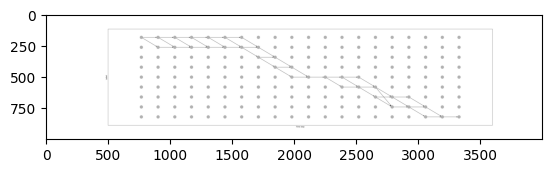

In [123]:
from matplotlib import pyplot as plt
from Tools.LossesAndMetrics.CustomRecurrenceMatrix import exportGraphFromMatrix
labels = [
    [1,0,7],
    [1,8,9],
    [8,12,14],
    [2,15,17],
]
labels2 = [
    [-1,-1,-1],
    [-1,-1,-1],
    [-1,-1,-1],
    [-1,-1,-1],
]

Time = tf.constant(20)

id=0
# convert and concat in one tensor of size: [2, 3, 3]
labels = tf.concat([tf.expand_dims(tf.convert_to_tensor(labels,dtype=tf.int32), 0), tf.expand_dims(tf.convert_to_tensor(labels2,dtype=tf.int32), 0)], axis=0)
seqLen = tf.convert_to_tensor(Time, dtype=tf.int32)
m = compute_recurrence_Matrix_from_labels(labels, seqLen, True)
exportGraphFromMatrix(m[id], [], "test4")

from Tools.LossesAndMetrics.CustomRecurrenceMatrix import getCustomGraphMatrixFromBounds

m2 = getCustomGraphMatrixFromBounds(list(labels[id]), seqLen, False)
exportGraphFromMatrix(m2, ["1","5"], "test")
# load and show the image "graph.png" :
plt.imshow(plt.imread("test.png"))
